<h1 style='color:purple' align='center'>Exploratory Data Analyis Project: Loan Defaulter Detection</h1>

Dataset is downloaded from here: https://www.kaggle.com/datasets/prakashraushan/loan-dataset

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.preprocessing import LabelEncoder

<h2 style='color:green'>Data Load: Loading Loan Distribution Data into a dataframe</h2>

In [12]:
# Load the dataset
df = pd.read_csv('LoanDataset.csv') 


# View the first few rows
print(df.head())

# Summary
print(df.describe())


   customer_id  customer_age customer_income home_ownership  \
0          1.0            22           59000           RENT   
1          2.0            21            9600            OWN   
2          3.0            25            9600       MORTGAGE   
3          4.0            23           65500           RENT   
4          5.0            24           54400           RENT   

   employment_duration loan_intent loan_grade   loan_amnt  loan_int_rate  \
0                123.0    PERSONAL          C  £35,000.00          16.02   
1                  5.0   EDUCATION          A   £1,000.00          11.14   
2                  1.0     MEDICAL          B   £5,500.00          12.87   
3                  4.0     MEDICAL          B  £35,000.00          15.23   
4                  8.0     MEDICAL          B  £35,000.00          14.27   

   term_years historical_default  cred_hist_length Current_loan_status  
0          10                  Y                 3             DEFAULT  
1           1     

<h2 style='color:green'>Data Cleaning: Handling NA values</h2>

In [13]:
# Check for missing values
print(df.isnull().sum())

# Optionally handle missing values
# For example, filling missing values or dropping rows/columns with missing values
df = df.dropna()  # Simple approach: drop rows with any missing values


customer_id                3
customer_age               0
customer_income            0
home_ownership             0
employment_duration      895
loan_intent                0
loan_grade                 0
loan_amnt                  1
loan_int_rate           3116
term_years                 0
historical_default     20737
cred_hist_length           0
Current_loan_status        4
dtype: int64


<h2 style='color:green'>Feature Engineering</h2>
 Remove non-numeric characters and commas from numerical columns

In [14]:


numerical_columns_with_symbols = ['customer_income', 'loan_amnt']

for column in numerical_columns_with_symbols:
    df[column] = df[column].apply(lambda x: re.sub(r'[^\d.]', '', str(x))).astype(float)

In [15]:
# Copy the dataframe to avoid modifying the original
encoded_df = df.copy()

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Encode categorical columns
categorical_columns = ['home_ownership', 'loan_intent', 'loan_grade', 'historical_default', 'Current_loan_status']

for column in categorical_columns:
    encoded_df[column] = label_encoder.fit_transform(encoded_df[column])

# Now you can proceed with the correlation analysis
correlation_matrix_encoded = encoded_df.corr()


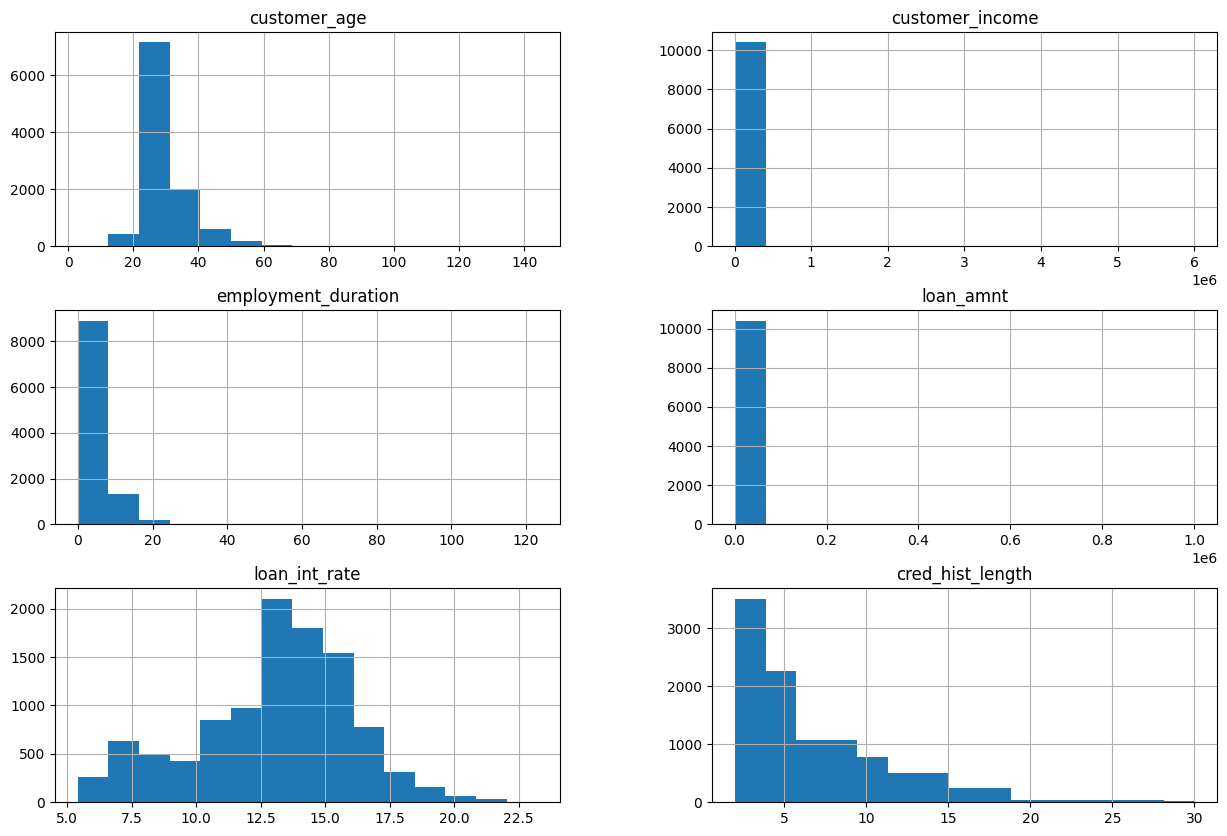

In [16]:
# Distribution of numerical features
numerical_features = ['customer_age', 'customer_income', 'employment_duration', 'loan_amnt', 'loan_int_rate', 'cred_hist_length']
df[numerical_features].hist(bins=15, figsize=(15, 10), layout=(3, 2))
plt.show()


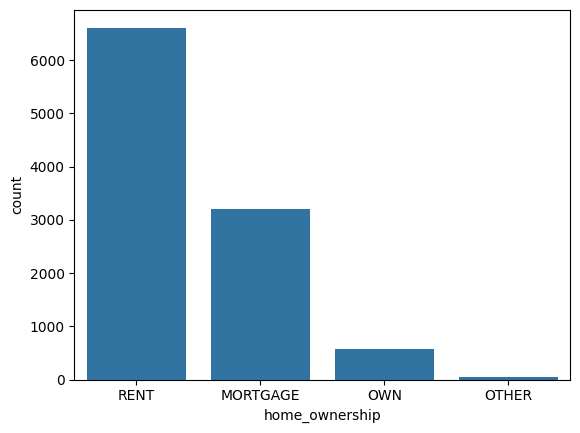

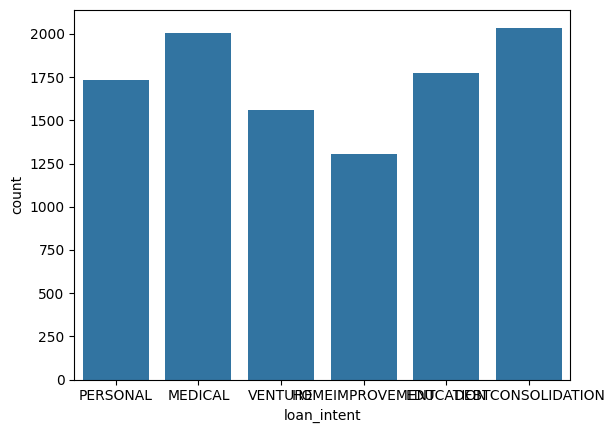

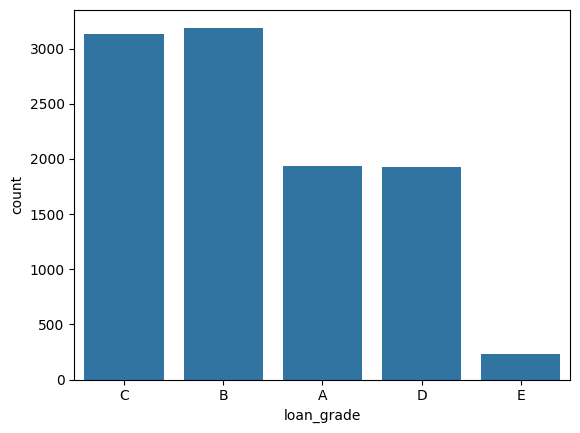

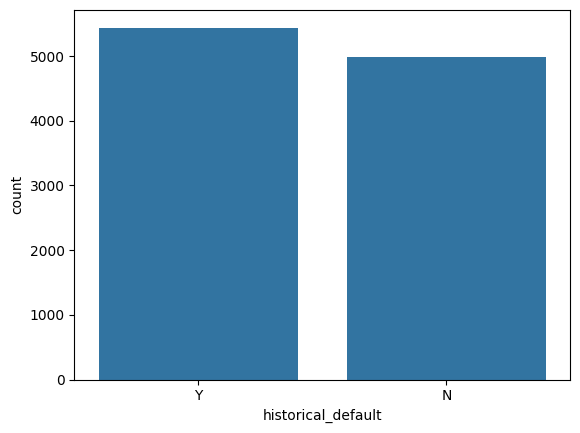

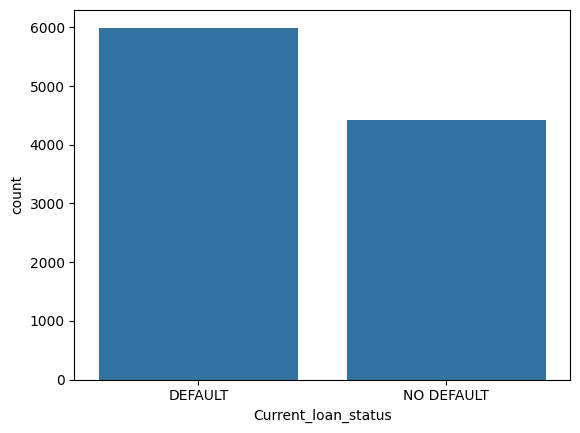

In [17]:
# Distribution of categorical features
for feature in categorical_columns:
    sns.countplot(x=feature, data=df)
    plt.show()


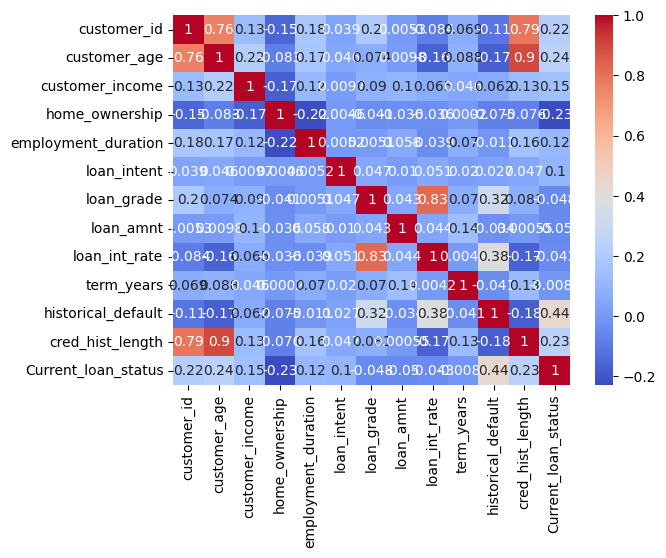

In [18]:

# Visualize correlation matrix
sns.heatmap(correlation_matrix_encoded, annot=True, cmap='coolwarm')
plt.show()




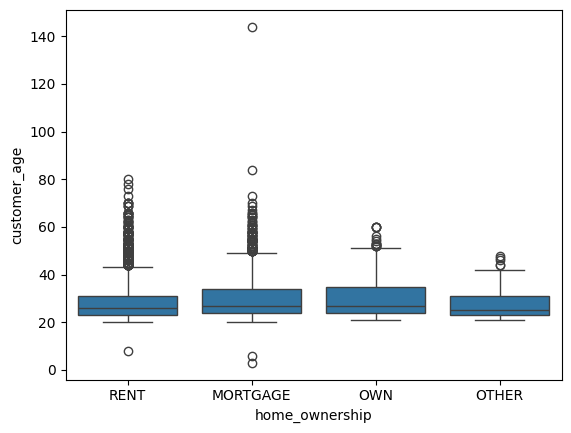

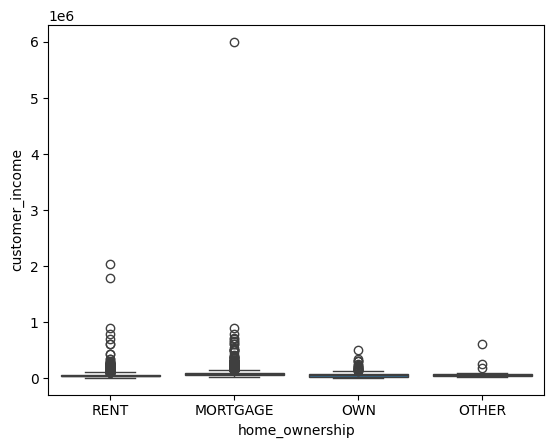

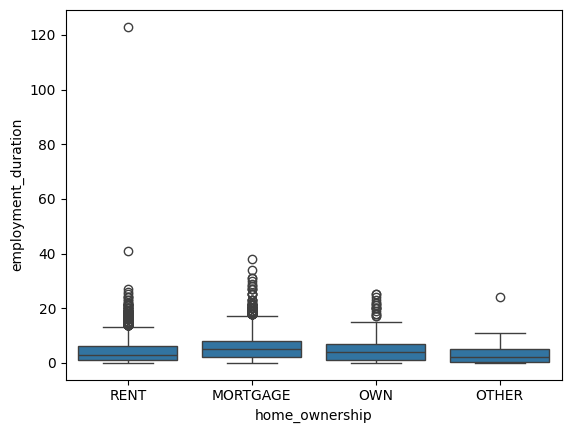

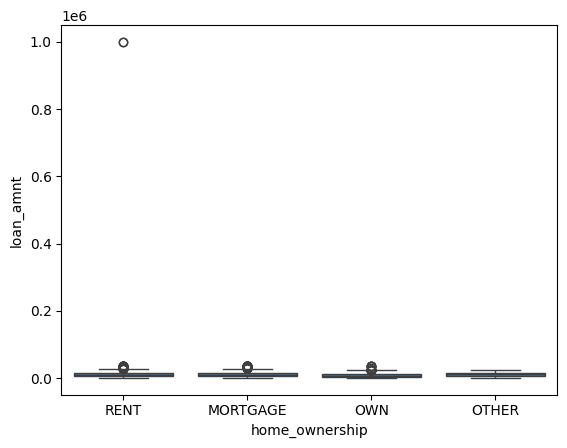

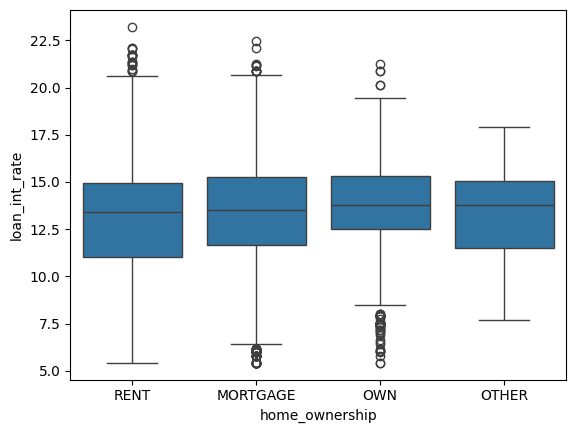

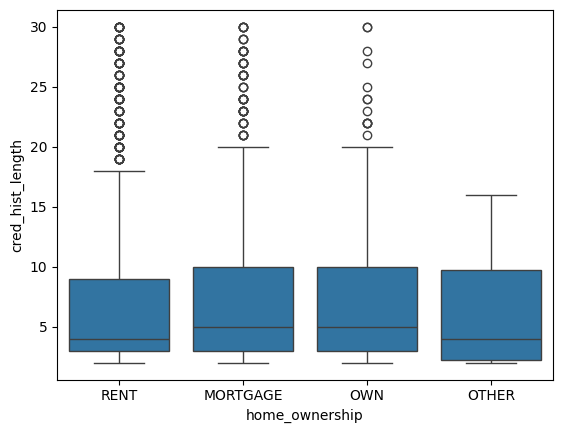

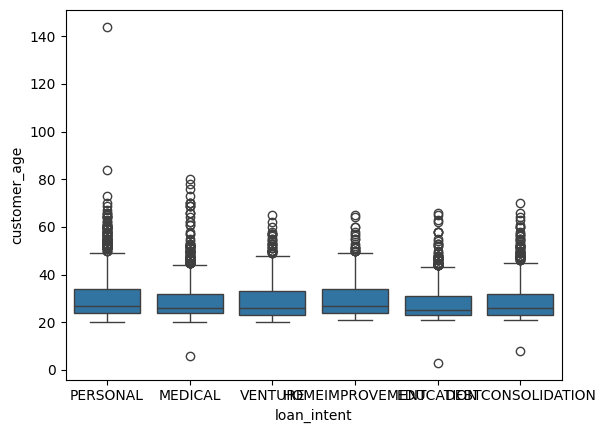

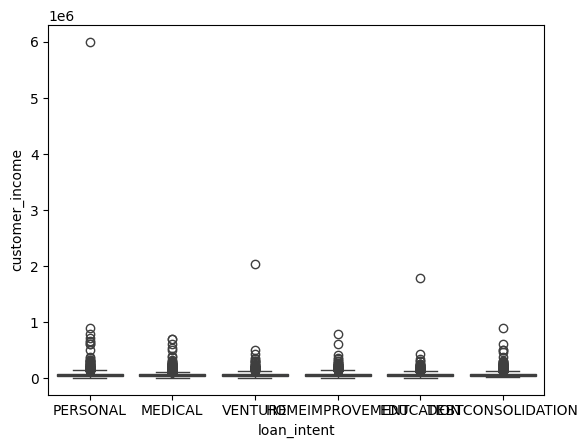

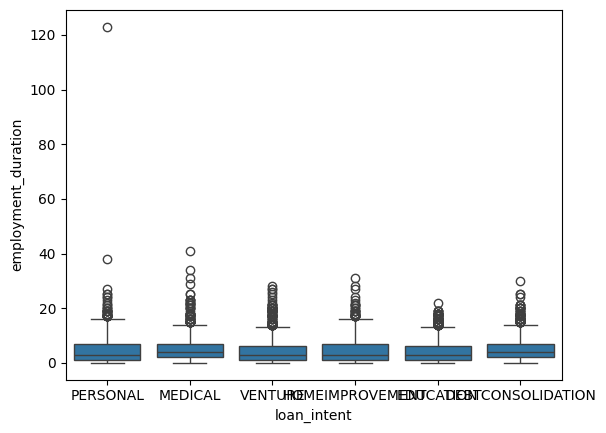

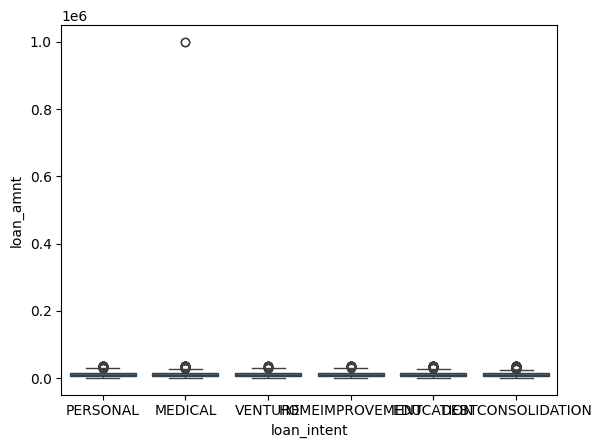

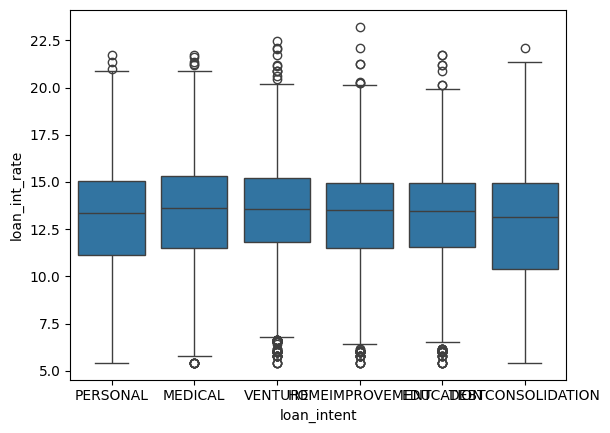

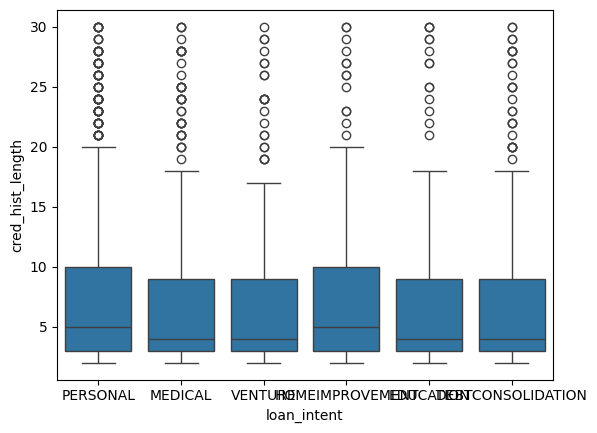

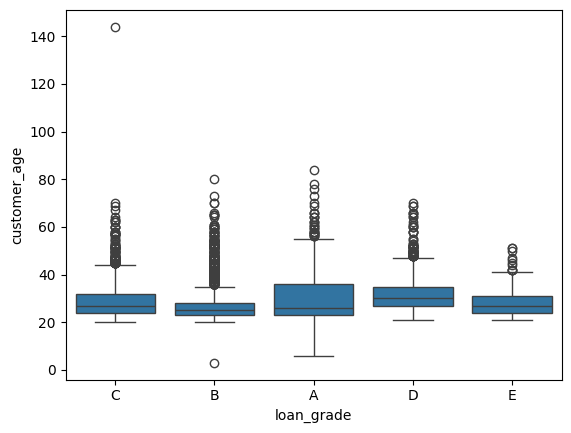

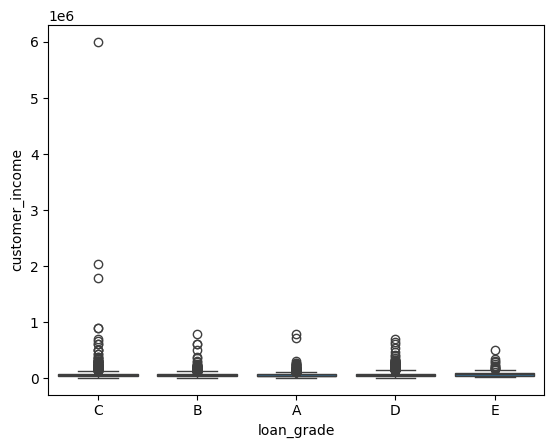

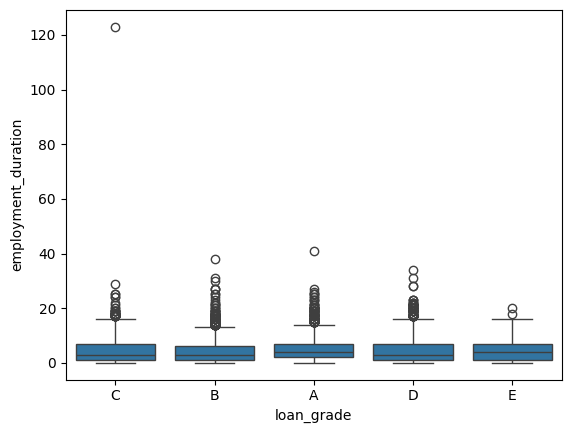

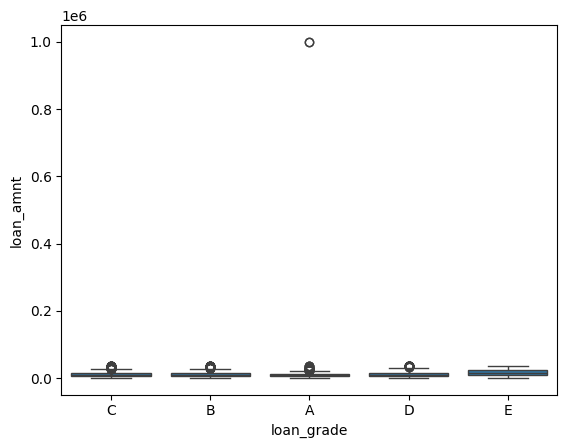

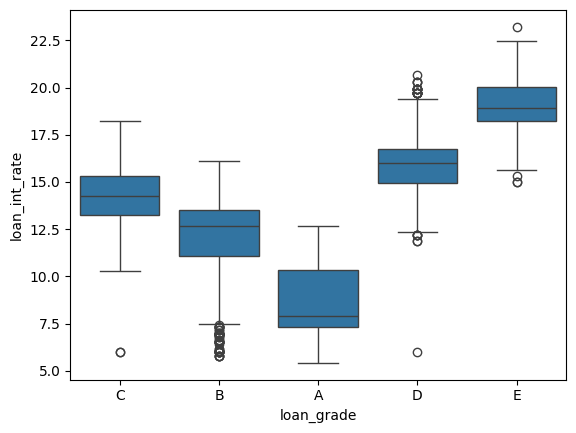

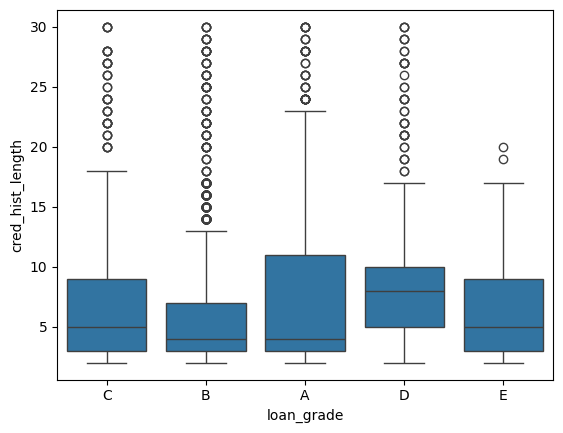

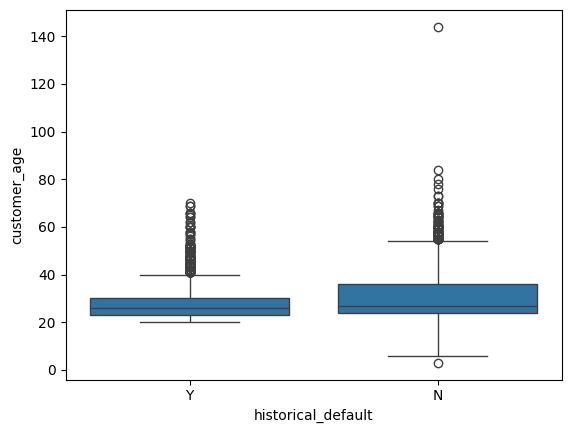

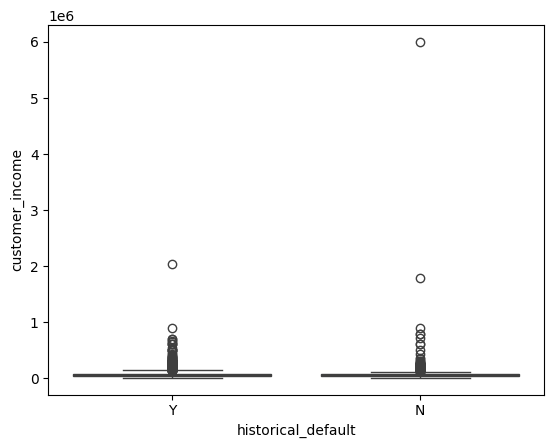

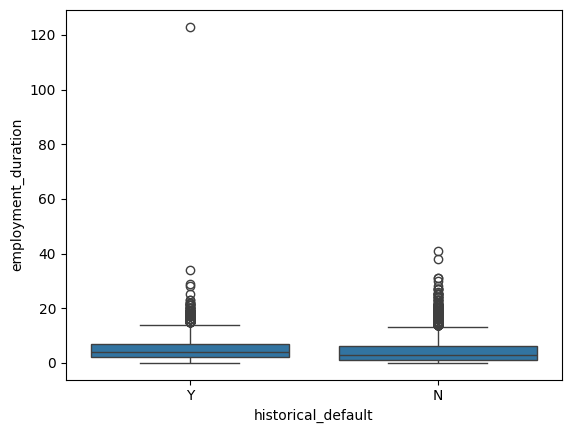

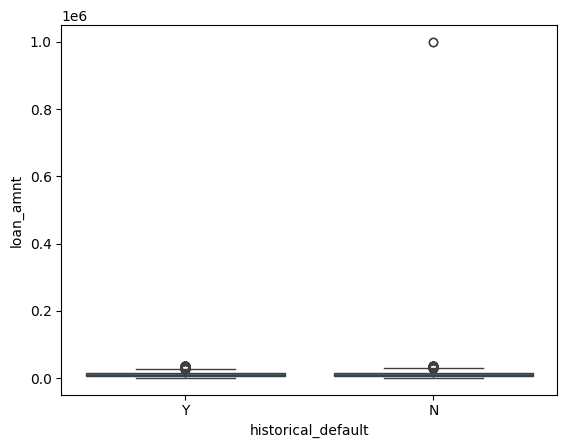

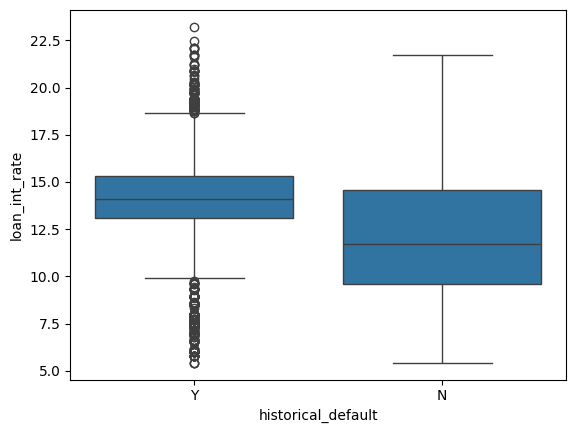

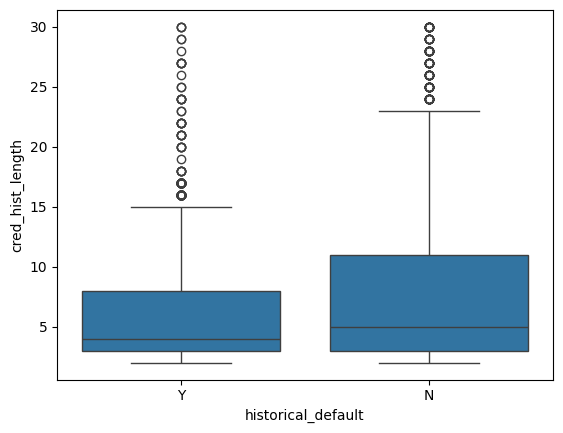

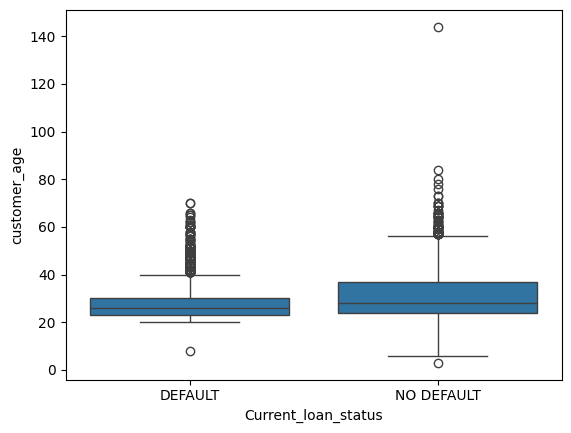

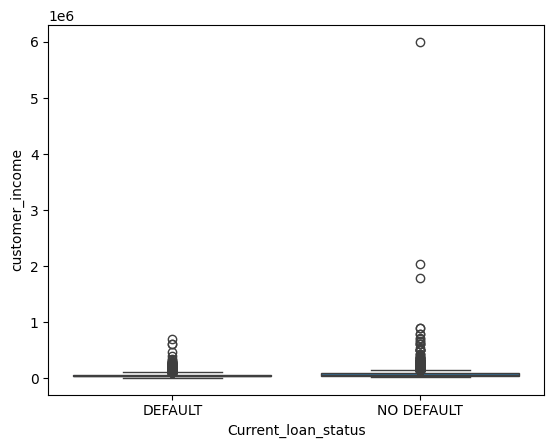

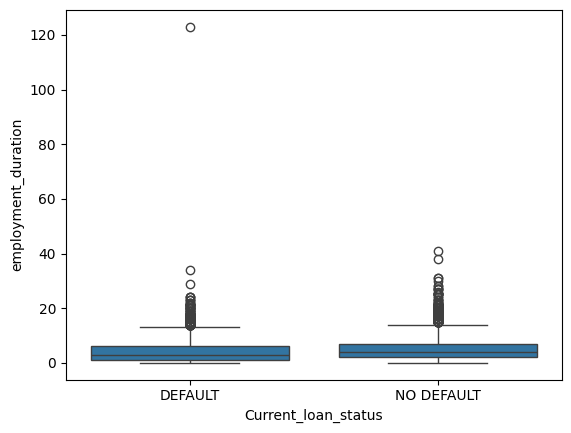

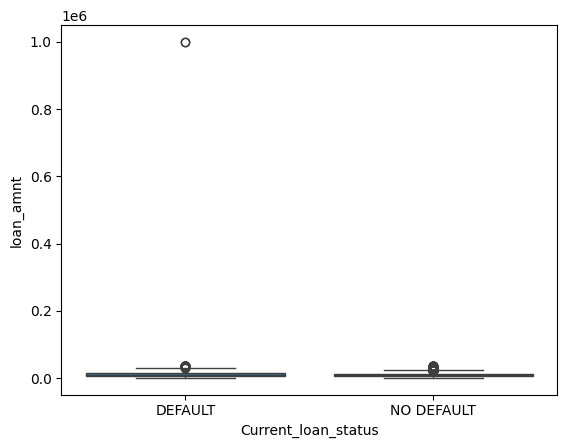

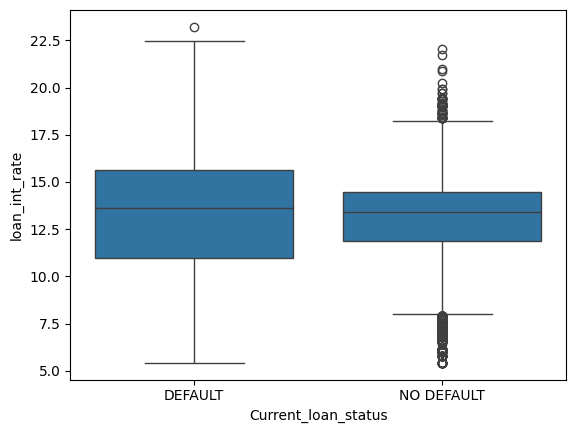

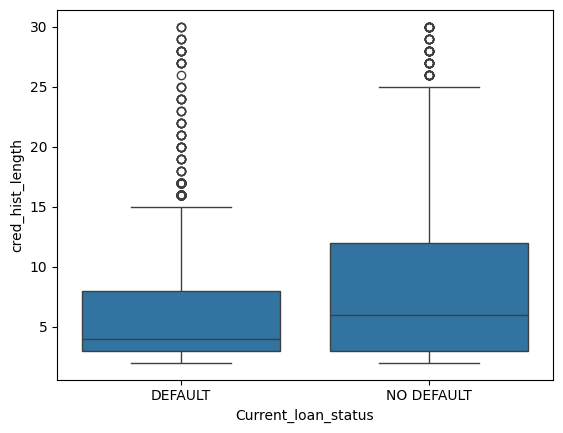

In [19]:
# Boxplots to show the distribution of numerical features across different categories
for feature in categorical_columns:
    for num_feature in numerical_features:
        sns.boxplot(x=feature, y=num_feature, data=df)
        plt.show()


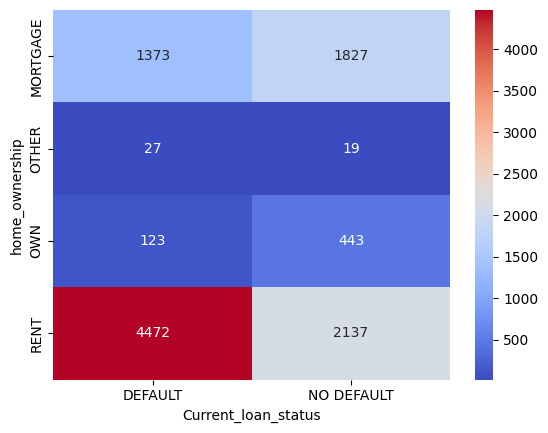

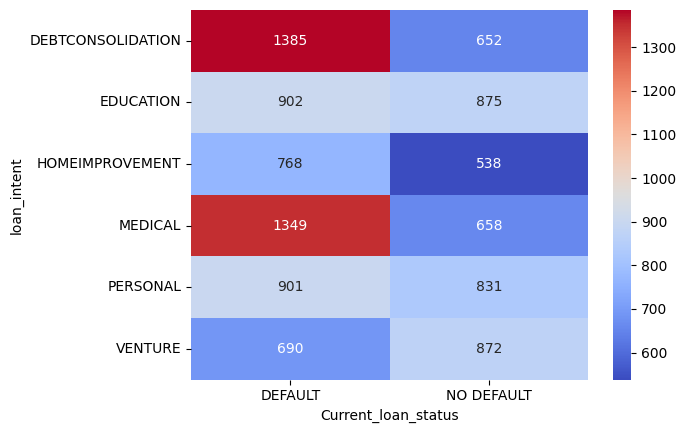

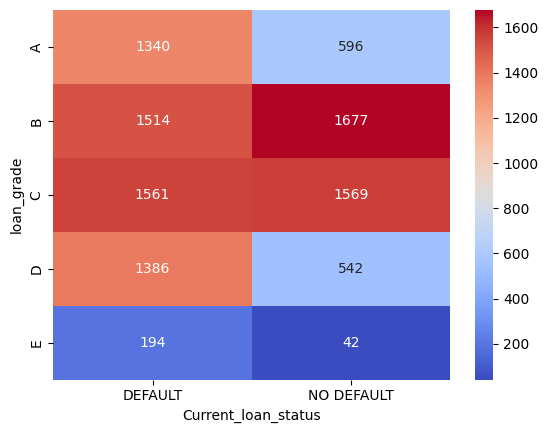

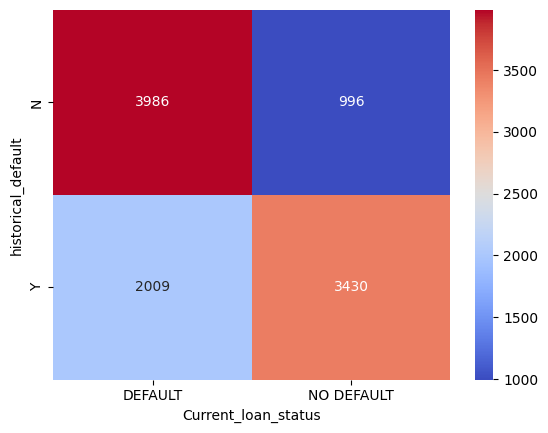

In [20]:
# Cross-tabulation and heatmaps for categorical features
for feature in categorical_columns:
    if feature != 'Current_loan_status':
        cross_tab = pd.crosstab(df[feature], df['Current_loan_status'])
        sns.heatmap(cross_tab, annot=True, cmap='coolwarm', fmt='d')
        plt.show()


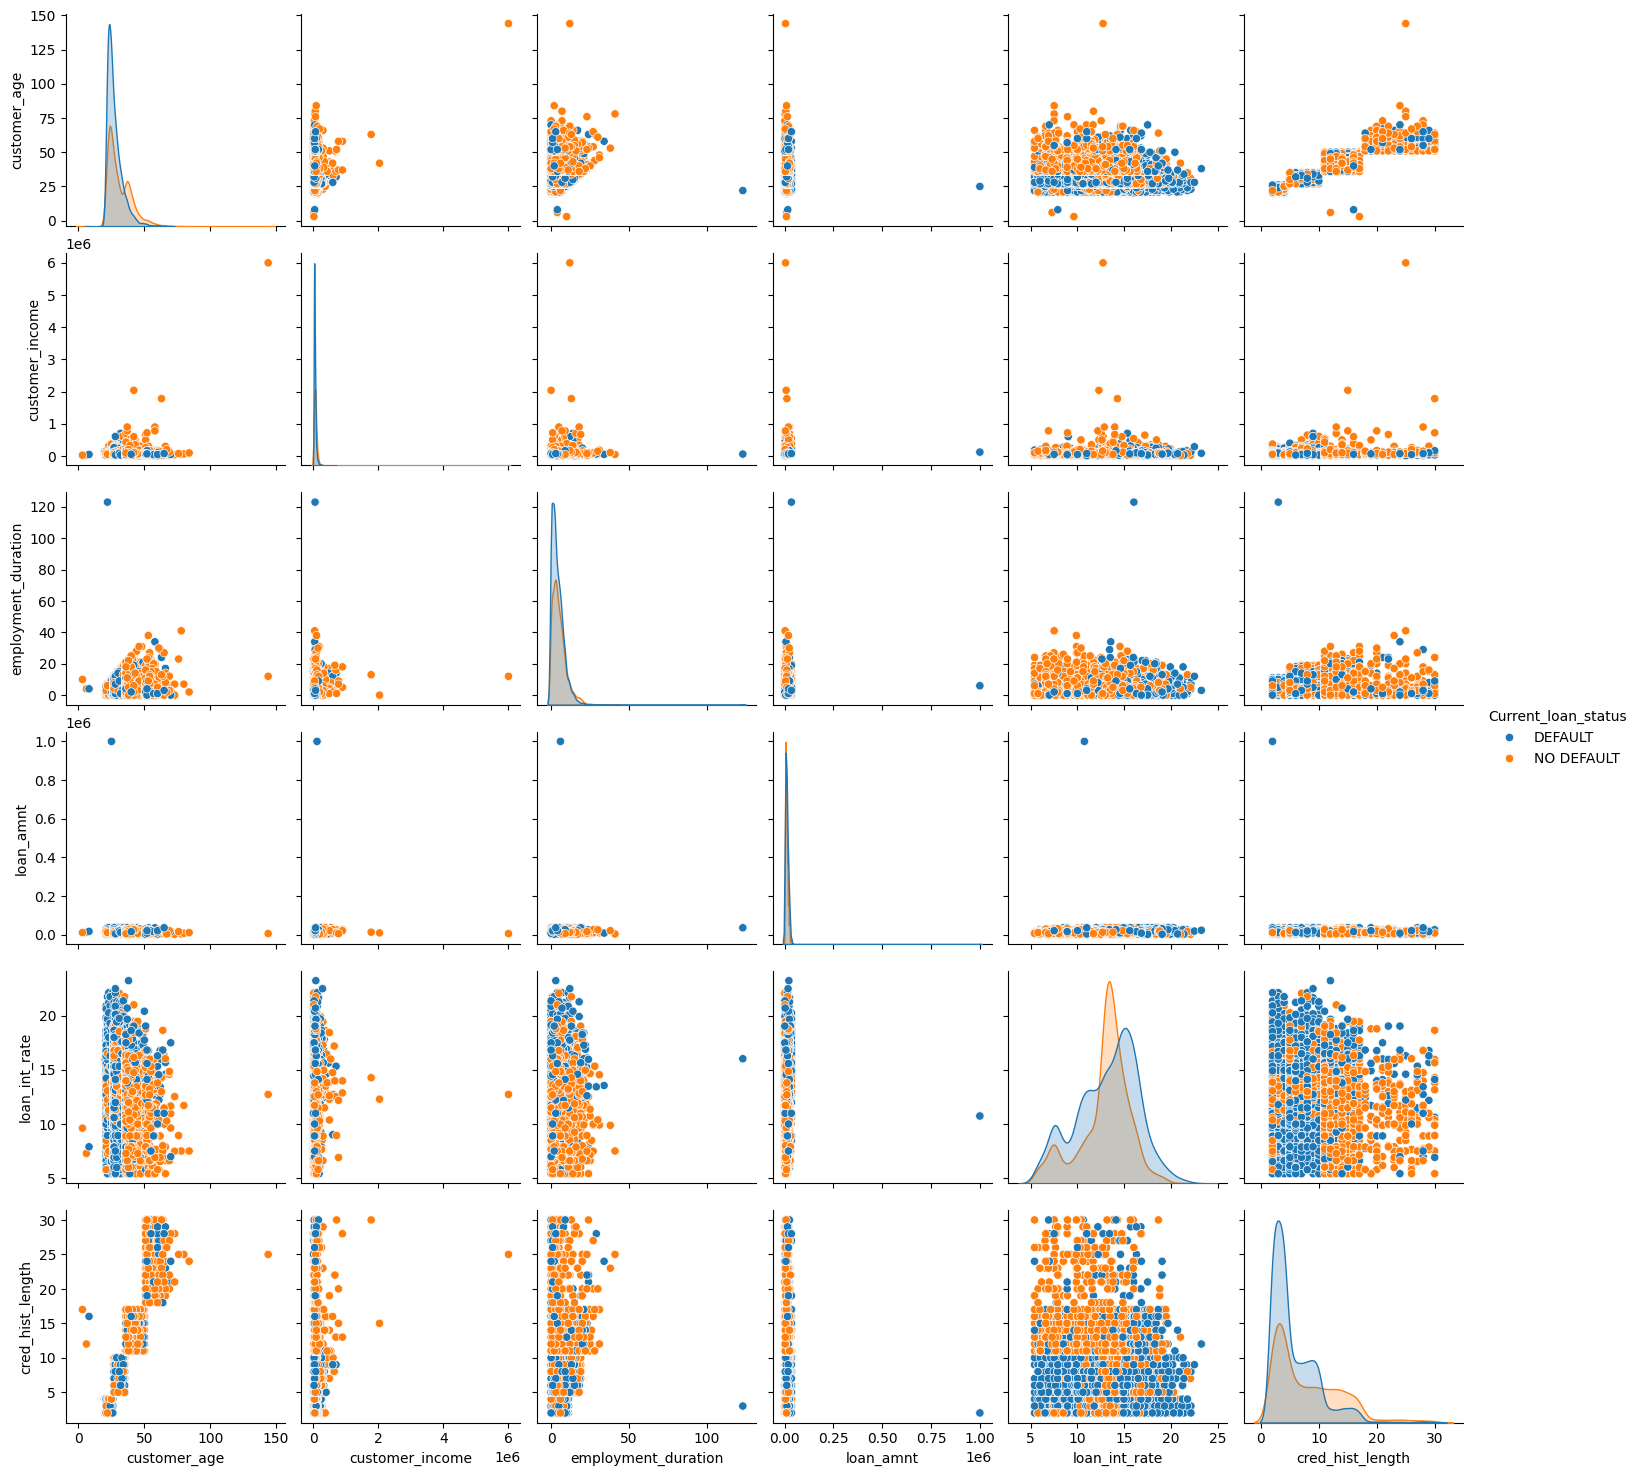

In [21]:
#Pair Plot
sns.pairplot(df, hue='Current_loan_status', vars=numerical_features)
plt.show()


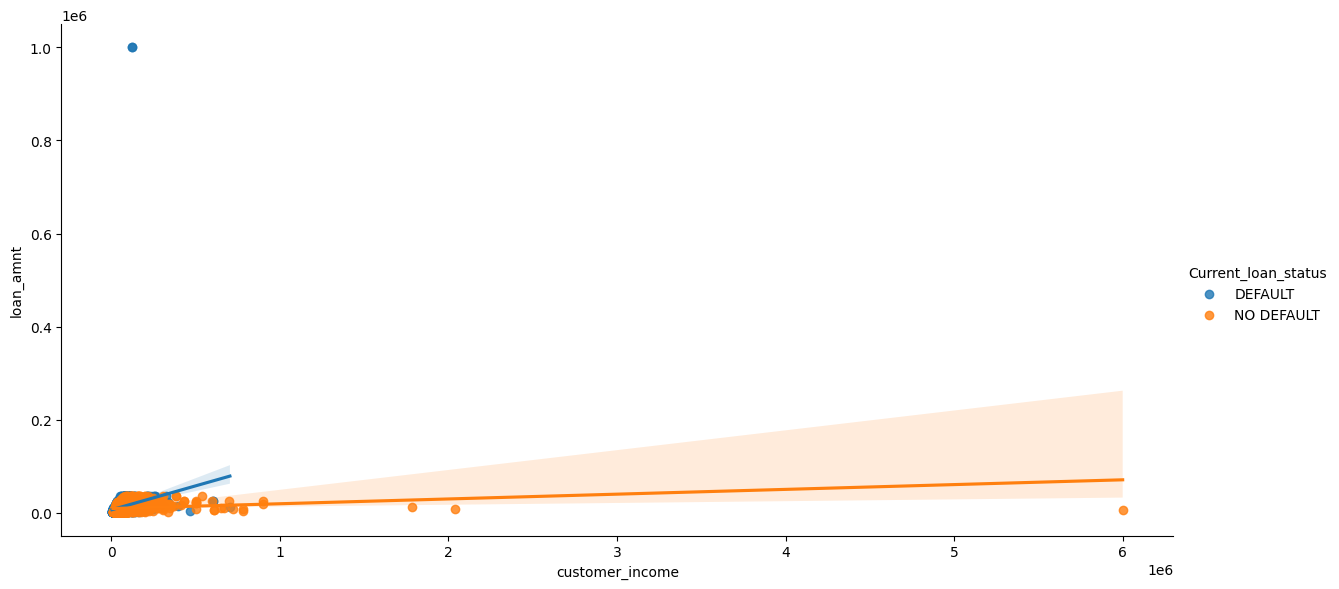

In [24]:
#Feature Interaction
sns.lmplot(x='customer_income', y='loan_amnt', hue='Current_loan_status', data=df, aspect=2, height=6)
plt.show()


In [23]:
#Insights